# PythonDataIES project - bezrealitky.cz
Authors: Tiep Luu Danh, Jan Malecha

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tqdm as tqdm
from lxml import html
import time
import itertools

## Bezrealitky pages class structure

**Estate (parent)** - class containing general methods for parsing bezrealitky websites
 - **Flat (child)** - standard properties, no special naming of methods as it type of majority of observations
 - **NBFlat (child)** - new-build properties, a group of new build estates that have very different page, methods for this class end with NB

In [2]:
class Estate:
    '''
    Defined as parent class for all possible version of bezrealitky pages
    
    Containing general methods used in scraping these websites
    '''
    def __init__(self, link):
        self.link = link
        self.soup = self.getSoup
        
    def getSoup(self):
        '''
        Initialize soup object.
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        
        return BeautifulSoup(r.text, 'html')   

In [3]:
class Flat(Estate):
    def __init__(self, link):
        '''
        Constructor for Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then flat parameters and coordinates are generated as Flat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParameters()
        
        # Getting coordinates of flat
        self.coordinates = self.getMap()
        
        # Getting resulting dataframe
        self.df = self.getDf()
        
    def getParameters(self):
        '''
        Get parameters of given estate - such as price, disposition, the state of the house, etc.
        '''
        bf_table = self.soup.find('div',{'data-element':"detail-description"}).find('table')
        table_extract = [i.text.strip() for i in bf_table.findAll('tr')]
        df_table = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        df = pd.DataFrame(df_table_split[[0,1]])
        df.columns = ['metric', 'value']
        df = df.set_index('metric')
        
        return df
        
#     def getMap(self):
#         '''
#         Get location of the property using embeded Google maps longtitute and lattitude parameters.
#         '''
#         bf_map = self.soup.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    def getMap(self):
        '''
        Get location of the property using longtitute and lattitude parameters.
        '''
        bf_map = self.soup.find('div','b-map__inner')
        f_lng = bf_map['data-lng']
        f_lat = bf_map['data-lat']
        loc_dict = {"lat" : f_lat, "long": f_lng}
        loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        return loc_df
    
    
    def getDf(self):
        '''
        Return a wide dataframe from getMap() and getParameters(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        df_map = self.getMap()
        df = pd.concat([df_par, df_map])
        df = df.T.set_index('Číslo inzerátu:')
#         df = pd.melt(df.T, id_vars = ['Číslo inzerátu:']).set_index('Číslo inzerátu:')
        return df    

**Example:**

In [138]:
Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/608778-nabidka-prodej-bytu-jilovska-hlavni-mesto-praha').getMap()

,value
lat,50.0239157
long,14.4284092


In [119]:
Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/603752-nabidka-prodej-bytu-mezi-skolami-praha').df

,Dispozice:,Plocha:,Cena:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,PENB:,Podlaží:,Balkón:,Terasa:,Výtah:,Garáž:,K dispozici od:,lat,long
Číslo inzerátu:,,,,,,,,,,,,,,,,
603752,3+kk,82 m²,5.590.000 Kč,Praha,Stodůlky,Osobní,Panel,C,4,Ano,Ne,Ne,Ne,01.08.2020,14.342979,50.052594


In [4]:
def NBFlat(Estate):
    def __init__(self, link):
        '''
        Constructor for new-build Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then new-build flat parameters and (coordinates) are generated as NBFlat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # Getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParametersNB()
        
        # Getting coordinates of flat
#         self.coordinates = self.getMapNB()
    
    def getParametersNB(self): 
        '''
        For new-build properties get parameters such as price, disposition, the state of the house
        '''
        bf_table = self.soup.find('div', {'id':'tabInformace'}).find('table')
        bf_table
        table_extract = [li.text.strip() for li in bf_table.findAll('tr', {'class':'cline'})]
        df_table  = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        pd.DataFrame(df_table_split[[0,1]], columns = ['metric', 'value'])
        df  = pd.concat(
                        [pd.DataFrame(np.array(df_table_split[[0,1]]), columns = ['metric', 'value']),
                        pd.DataFrame(np.array(df_table_split[[2,3]]), columns = ['metric', 'value'])]
                        )

        return df
    
    def getDf(self):
        '''
        Return a wide dataframe from getMapNB() and getParametersNB(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        return df_par
#         df_map = self.getMap()
#         df = pd.concat([df_par, df_map])
#         df = pd.melt(df.T, id_vars = ['lat','long'])
#         return df
    
        
# FOLLOWING METHOD is currently work in progress
#     def getMapNB(self) 
#         '''
#         Get location of the property using embeded google maps longtitute and lattitude parameters
#         '''
#         bf = self.getSoup()
#         bf_map = bf.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    

# Downloader class

In [5]:
class Downloader:
    '''
    Download all links of real estate properties on the given website
    '''
    def __init__(self, link):
        '''
        Provide real estate webpage to extract the properties links
        '''
        self.link = link
        self.start_num = 1
        self.soup = self.getSoup()
        self.pages = self.getPages()
        self.links = self.getLinks()
        self.df = self.Scraper()
        
        self.flats = []
        self.failed_links = []
        
    def getSoup(self):
        '''
        Initialize soup object
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        return BeautifulSoup(r.text, 'lxml')
    
#     def getPagesSoup(self):
#         for page in self.pages:
#             r = requests.get(page)
#             r.encoding = 'UTF-8'
#             return BeautifulSoup(r.text, 'lxml')

        
    def getPages(self):
        '''
        Generates a list of all pages for specific search on bezrealitky webpage
        '''
        all_pages = [self.link] # create a list of pages
        start_num = self.start_num # first page
        last_page = int(self.soup.find('ul', class_="pagination justify-content-md-end").findAll('li')[-2].text) # number of last page

        for i in range(start_num, last_page):
            offer_page = self.link + f'&page={i+1}'  # adding a page number at the end of each url
            all_pages.append(offer_page) # storage of tables for each flat

        return all_pages
    
    def getLinks(self):
        '''
        Generate a list of all flat links from a page. If there are multiple pages, for loop recursively get links from all pages
        '''    
        links_list = list()
        for page in self.pages:
            base_url = 'https://www.bezrealitky.cz'
            r = requests.get(page)
            r.encoding = 'UTF-8'
            wp = BeautifulSoup(r.text, 'lxml')
            links = wp.findAll('div', {'product__body'})
            for equity in links:
                if 'https://www.bezrealitky.cz' in equity.find('a')['href']:
                    links_list.append(equity.find('a')['href'])
                else: 
                    links_list.append(base_url + equity.find('a')['href'])
        return links_list
    
#     def downloadFlats(self,pause=0.5):
#         '''
#         Download all links stored in self.links and store it in self.flats
#         pause -- how long to pause between requests? (in seconds)
#         tqdm -- the progress bar showing a progress of iterator
#         '''
#         count = len(self.links)
#         print('Downloading all {} flats ...'.format(count))

#         for link in self.links:
#             flat = Flat(link)
#             self.flats.append(flat.df)
#             time.sleep(pause)
            
#     def saveDf(self):
#         data = {}
#         data = pd.DataFrame([x.df for x in self.flats])
#         self.df = data
            
            
    def Scraper(self):
        '''
        Scraping information for each flat link
        '''
        database = pd.DataFrame()
        counter = 0
        for link in self.links:
            try:
                flat = Flat(link)
                database = database.append(flat.df, sort=False)
                
                # printing scraping information
                counter = counter + 1
                if counter % 10 == 0:
                    print(f'>> {counter} flats scraped')
                    time.sleep(5)
            except Exception as error:
                self.failed_links.append(link)
                # print(error)
        return database

        #saving final database as attribute
#         self.database = database


# Performing scraping

In [90]:
dl = Downloader('https://www.bezrealitky.cz/vypis/nabidka-pronajem/byt/praha/praha-nove-mesto?_token=npA8jW3mMUQ0EuxpijEAZFi8gjEybSaJmTKwvArkpRg')

>> 10 flats scraped
>> 20 flats scraped
>> 30 flats scraped
>> 40 flats scraped
>> 50 flats scraped
>> 60 flats scraped
>> 70 flats scraped
>> 80 flats scraped
>> 90 flats scraped
>> 100 flats scraped
>> 110 flats scraped
>> 120 flats scraped
>> 130 flats scraped
>> 140 flats scraped
>> 150 flats scraped
>> 160 flats scraped
>> 170 flats scraped
>> 180 flats scraped
>> 190 flats scraped
>> 200 flats scraped
>> 210 flats scraped
>> 220 flats scraped
>> 230 flats scraped


In [91]:
dl.df

,Internet:,Dispozice:,Plocha:,Cena:,Poplatky:,Vratná kauce:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,...,lat,long,Vybavenost:,Stáří:,Provedení:,Typ vytápění:,Podlaží v rámci domu:,Rekonstrukce:,Předzahrádka:,Novostavba:
Číslo inzerátu:,,,,,,,,,,,,,,,,,,,,,
602233,,3+1,85 m²,22.000 Kč,3.000 Kč,25.000 Kč,Praha,Nové Město,Osobní,Cihla,...,50.078073,14.423947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483454,,3+kk,77 m²,23.000 Kč,750 Kč,NaN,Praha,Nové Město,Osobní,Cihla,...,50.0705361,14.4187017,Vybavený,1 - 10,standardní: běžné materiály a technologie,plynový kotel,první až předposlední podlaží,vše,NaN,NaN
524239,,2+kk,39 m²,15.500 Kč,750 Kč,NaN,Praha,Nové Město,Osobní,Cihla,...,50.070427,14.4189049,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
558443,,3+1,81 m²,25.500 Kč,3.000 Kč,NaN,Praha,Nové Město,Osobní,Cihla,...,50.0705361,14.4187017,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602091,,1+kk,35 m²,11.500 Kč,1.500 Kč,15.000 Kč,Praha,Nové Město,Družstevní,Cihla,...,50.070531,14.430608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602021,,3+kk,110 m²,24.000 Kč,3.000 Kč,30.000 Kč,Praha,Nové Město,Družstevní,Cihla,...,50.078251,14.424879,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324257,,3+kk,70 m²,16.999 Kč,2.999 Kč,15.000 Kč,Praha,Nové Město,Osobní,Cihla,...,50.0786077,14.4172987,Vybavený,NaN,NaN,plynový kotel,NaN,NaN,NaN,NaN
166213,,2+1,72 m²,15.000 Kč,4.500 Kč,19.500 Kč,Praha,Nové Město,Osobní,Cihla,...,50.0808055,14.4197518,Vybavený,1 - 10,NaN,plynový kotel,NaN,interiér,116 m²,NaN
544787,,Garsoniéra,19 m²,8.000 Kč,2.500 Kč,16.000 Kč,Praha,Nové Město,Osobní,Cihla,...,50.0688474,14.415003,Částečně,NaN,standardní: běžné materiály a technologie,centrální,přízemí,NaN,NaN,NaN


# Exploratory analysis

In [76]:
NM_sale = dl.df.copy(deep = True)
NM_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 604082 to 596704
Data columns (total 24 columns):
Internet:                21 non-null object
Dispozice:               21 non-null object
Plocha:                  21 non-null object
Cena:                    21 non-null object
Město:                   21 non-null object
Městská část:            21 non-null object
Typ vlastnictví:         21 non-null object
Typ budovy:              21 non-null object
PENB:                    21 non-null object
Vybavenost:              12 non-null object
Podlaží:                 21 non-null object
Balkón:                  21 non-null object
Terasa:                  21 non-null object
Výtah:                   21 non-null object
Garáž:                   21 non-null object
K dispozici od:          21 non-null object
Typ vytápění:            11 non-null object
Podlaží v rámci domu:    10 non-null object
Rekonstrukce:            10 non-null object
lat                      21 non-null object
long         

In [77]:
type(NM_sale['lat'][0])

str

In [52]:
NM_sale['PENB:'].unique()

array(['C', 'G', 'F', 'E'], dtype=object)

In [50]:
NM_sale.iloc[:,11:15]

,Balkón:,Terasa:,Výtah:,Garáž:
Číslo inzerátu:,,,,
604082,Ne,Ano,Ano,Ne
604965,Ne,Ne,Ne,Ne
604969,Ne,Ne,Ano,Ne
605098,Ne,Ne,Ano,Ne
605100,Ne,Ne,Ano,Ne
605104,Ne,Ne,Ano,Ne
607857,Ne,Ano,Ano,Ne
598505,Ne,Ne,Ne,Ne
600538,Ne,Ano,Ne,Ne


In [80]:
# NM_sale['Plocha:'] = NM_sale['Plocha:'].str.extract('(\d+)').astype(float)
# NM_sale["Cena:"] = NM_sale["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)
NM_sale["lat"] = NM_sale["lat"].astype(float)
NM_sale["long"] = NM_sale["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_sale = NM_sale[num_col]
num_NM_sale.head()

,Plocha:,Cena:,lat,long
Číslo inzerátu:,,,,
604082,96.0,11900000.0,50.076385,14.428864
604965,112.0,10800000.0,50.081196,14.418336
604969,178.0,16450000.0,50.078518,14.424050
605098,82.0,12220000.0,50.091312,14.431711
605100,165.0,18400000.0,50.077881,14.424228


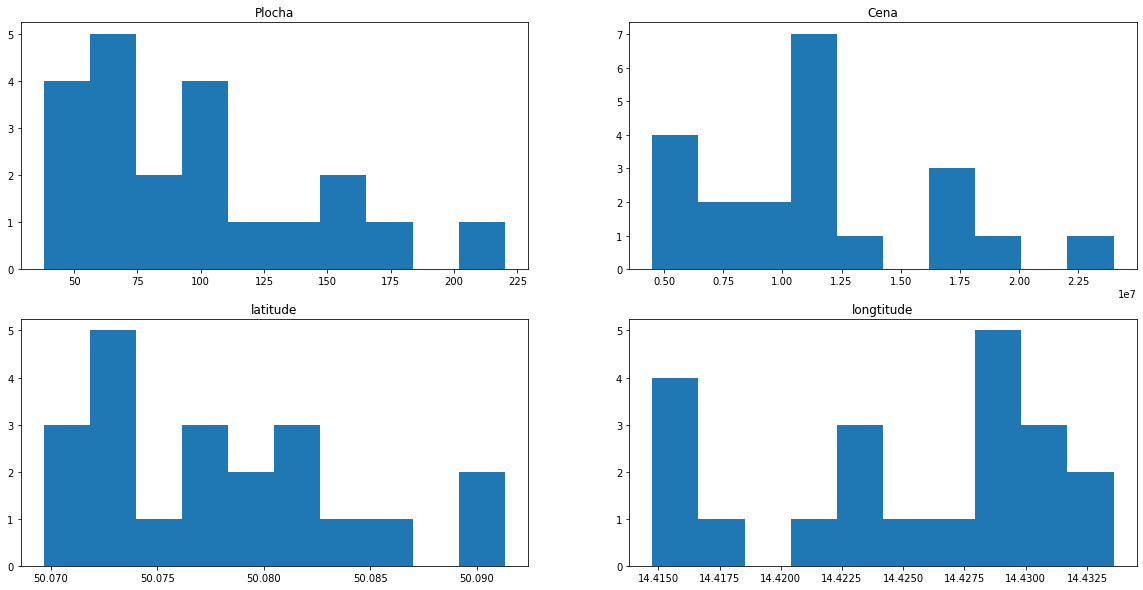

In [108]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_sale['Plocha:'])
plt.title('Plocha')

plt.subplot(2,2,2)
plt.hist(num_NM_sale['Cena:'])
plt.title('Cena')

plt.subplot(2,2,3)
plt.hist(num_NM_sale['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_sale['long'])
plt.title('longtitude')

plt.show()

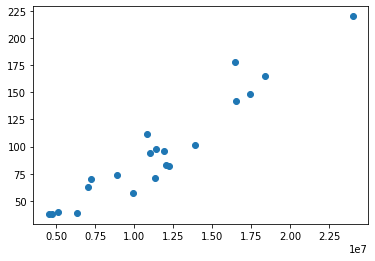

In [37]:
plt.scatter(NM_sale['Cena:'], NM_sale['Plocha:'])

In [38]:
print(NM_sale['Cena:'].describe())

count    2.100000e+01
mean     1.146971e+07
std      5.033842e+06
min      4.500000e+06
25%      7.200000e+06
50%      1.132900e+07
75%      1.390000e+07
max      2.400000e+07
Name: Cena:, dtype: float64


In [111]:
NM_rent = dl.df.copy(deep = True)
NM_rent.info()
# NM_rent.to_csv('NM_rent.csv')


<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 602233 to 411852
Data columns (total 27 columns):
Internet:                234 non-null object
Dispozice:               234 non-null object
Plocha:                  234 non-null object
Cena:                    234 non-null object
Poplatky:                231 non-null object
Vratná kauce:            198 non-null object
Město:                   234 non-null object
Městská část:            234 non-null object
Typ vlastnictví:         234 non-null object
Typ budovy:              234 non-null object
PENB:                    198 non-null object
Podlaží:                 227 non-null object
Balkón:                  234 non-null object
Terasa:                  234 non-null object
Výtah:                   234 non-null object
Garáž:                   234 non-null object
K dispozici od:          218 non-null object
lat                      234 non-null object
long                     234 non-null object
Vybavenost:              141 non-null

In [109]:
NM_rent['Plocha:'] = NM_rent['Plocha:'].str.extract('(\d+)').astype(float)
NM_rent["Cena:"] = NM_rent["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)
NM_rent["lat"] = NM_rent["lat"].astype(float)
NM_rent["long"] = NM_rent["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_rent = NM_rent[num_col]
num_NM_rent.head()

,Plocha:,Cena:,lat,long
Číslo inzerátu:,,,,
602233,85.0,22000.0,50.078073,14.423947
483454,77.0,23000.0,50.070536,14.418702
524239,39.0,15500.0,50.070427,14.418905
558443,81.0,25500.0,50.070536,14.418702
602091,35.0,11500.0,50.070531,14.430608


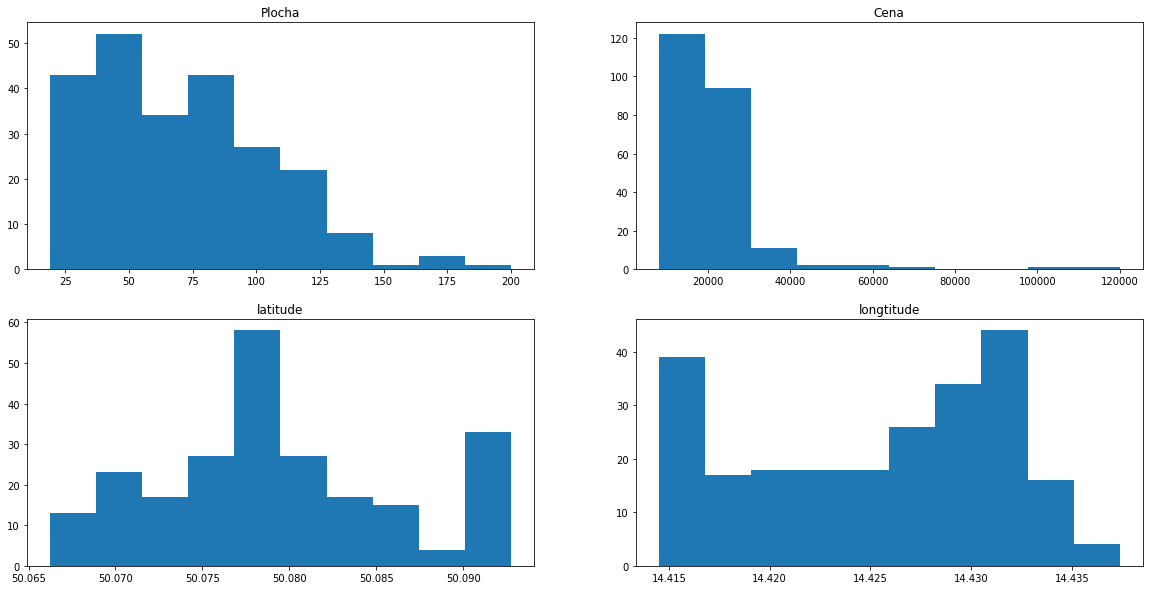

In [110]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_rent['Plocha:'])
plt.title('Plocha')

plt.subplot(2,2,2)
plt.hist(num_NM_rent['Cena:'])
plt.title('Cena')

plt.subplot(2,2,3)
plt.hist(num_NM_rent['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_rent['long'])
plt.title('longtitude')

plt.show()